In [8]:
import gabor_pyramid
from loaders import pvc1, pvc2, pvc4
import separable_net
import torch
import os

from torch import nn
from torchvision import transforms

data_root = './data'

trainset = pvc4.PVC4(os.path.join(data_root, 'crcns-pvc4'), 
                            split='train', 
                            nx=65,
                            ny=65,
                            nt=32, 
                            ntau=9,
                            nframedelay=0)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=1, 
                                          shuffle=False)

device = torch.device('cuda')

subnet = nn.Sequential(
    gabor_pyramid.GaborPyramid(4),
    transforms.Normalize(2.2, 2.2)
)
subnet.to(device=device)

Sequential(
  (0): GaborPyramid()
  (1): Normalize(mean=2.2, std=2.2)
)

In [138]:
net = separable_net.LowRankNet(subnet, 
                               trainset.total_electrodes, 
                               16, 
                               65, 
                               65, 
                               trainset.ntau,
                               sampler_size=9).to(device)

net.to(device=device)
net.load_state_dict(torch.load('models/pyramid/xception.ckpt108377-2020-12-17 16-02-04.793218.pt'))

<All keys matched successfully>

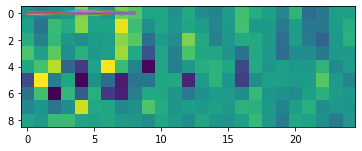

In [139]:
import matplotlib.pyplot as plt
Wt = net.wt.cpu().detach().numpy()
plt.plot(Wt)
plt.imshow(Wt)

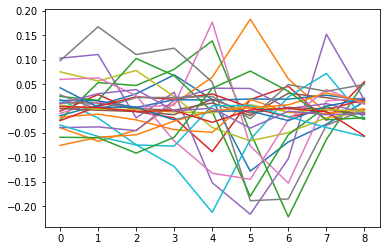

In [140]:
_ = plt.plot(Wt)

Loading batch 0
Loading batch 50
Loading batch 100
Loading batch 150
Loading batch 200
Loading batch 250
Loading batch 300
Loading batch 350
Loading batch 400
Loading batch 450
Loading batch 500
Loading batch 550
Loading batch 600
Loading batch 650
Loading batch 700
Loading batch 750
Loading batch 800
Loading batch 850


tensor(0.0108, device='cuda:0')

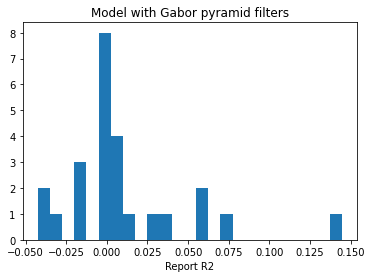

In [144]:
import numpy as np
totals = 0
n = 0

reportset = pvc4.PVC4(os.path.join(data_root, 'crcns-pvc4'), 
                        split='tune', 
                        nt=32,
                        nx=65,
                        ny=65,
                        ntau=9,
                        nframedelay=0)

reportloader = torch.utils.data.DataLoader(reportset, 
                                           batch_size=1, 
                                           shuffle=False)

net.eval()

n = torch.zeros(trainset.total_electrodes, device=device)
total_labels = torch.zeros_like(n)
total_labels_squared = torch.zeros_like(n)
total_labels_sse = torch.zeros_like(n)
total_timesteps = torch.zeros(trainset.total_electrodes, dtype=torch.long, device=device)

L = np.nan * torch.ones(100000, trainset.total_electrodes, device=device)
P = np.nan * torch.ones_like(L)
with torch.no_grad():
    for i, data in enumerate(reportloader, 0):
        if i % 50 == 0:
            print(f"Loading batch {i}")
        X, M, labels = data
        X, M, labels = X.to(device), M.to(device), labels.to(device)
        
        fwd = net.forward((X, M))
        
        rg = M.any(axis=0)
        labels = labels[:, rg, :]

        
        M = M[:, rg]

        n[rg] += M.sum(axis=0) * labels.shape[2]
        total_timesteps[rg] += labels.shape[2]
        total_labels[rg] += (M.reshape(M.shape[0], M.shape[1], 1) * labels).sum(0).sum(1)
        total_labels_squared[rg] += (M.reshape(M.shape[0], M.shape[1], 1) * (labels ** 2)).sum(0).sum(1)
        total_labels_sse[rg] += ((M.reshape(M.shape[0], M.shape[1], 1) * (labels - fwd)) ** 2).sum(0).sum(1)
        
        mask = torch.nonzero(rg)
        for k, j in enumerate(mask):
            slc = slice(total_timesteps[j].item()-labels.shape[2], total_timesteps[j].item())
            L[slc, j.item()] = labels[:, k, :]
            P[slc, j.item()] = fwd[:, k, :]
            
variance_baseline = total_labels_squared / n - (total_labels / n) ** 2

variance_after = total_labels_sse / n

r2 = 1 - variance_after / variance_baseline
plt.hist(r2.cpu().squeeze().numpy(), 25)
plt.xlabel('Report R2')
plt.title('Model with Gabor pyramid filters')

r2.mean()

Loading batch 0
Loading batch 50
Loading batch 100
Loading batch 150
Loading batch 200
Loading batch 250
Loading batch 300
Loading batch 350
Loading batch 400
Loading batch 450


tensor(-0.1156, device='cuda:0')

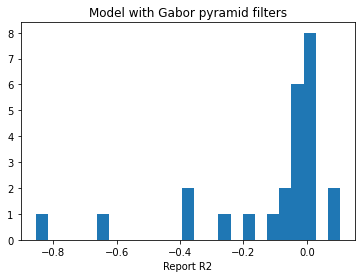

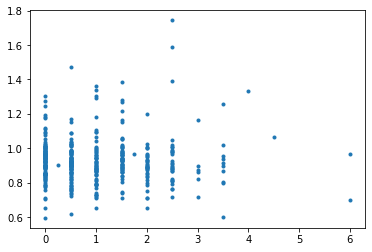

In [130]:

#plt.plot(labels.squeeze().cpu().detach())
idx = 7
#plt.plot(L[:, idx].cpu())
#plt.plot(P[:, idx].cpu())
r2[idx]

plt.plot(L[:, idx].cpu(), P[:, idx].cpu(), '.')
#good_rg = ~np.isnan(L[:, idx].cpu().numpy())
#print(r2[idx])
#print(np.corrcoef(L[good_rg, idx].cpu().numpy(), P[good_rg, idx].cpu().numpy())[0, 1] ** 2)